# Cost functions

We give an in-depth guide on how to use the built-in cost functions.

The iminuit package comes with a couple of common cost functions that you can import from `iminuit.cost` for convenience. Of course, you can write your own cost functions to use with iminuit, but most of the cost function is always the same. What really varies is the statistical model which predicts the probability density as a function of the parameter values. This you still have to provide yourself and the iminuit package will not include machinery to build statistical models (that is out of scope).

Using the built-in cost functions is not only convenient, they also have some extra features.

* Support of fitted weighted histograms.
* Technical tricks improve numerical stability.
* Optional numba acceleration (if numba is installed).
* Cost functions can be added to fit data sets with shared parameters.
* Temporarily mask data.

We demonstrate each cost function on a standard example from high-energy physics, the fit of a peak over some smooth background (here taken to be constant).

In [76]:
from iminuit import cost, Minuit
# faster than scipy.stats functions
from numba_stats import truncnorm, truncexpon, norm, expon 
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import multivariate_normal as mvnorm
# accurate numerical derivatives
from jacobi import jacobi

We generate our data by sampling from a Gaussian peak and from exponential background in the range 0 to 2. The original data is then binned. One can fit the original or the binned data.

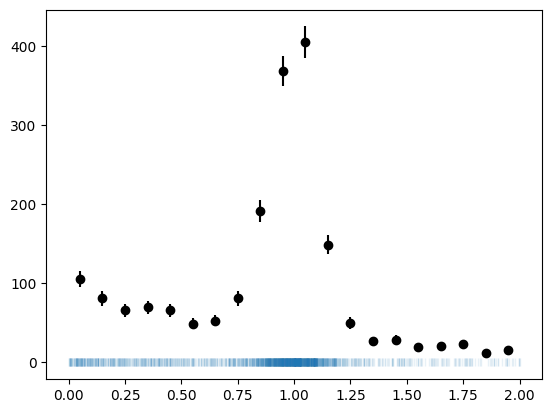

In [77]:
xr = (0, 2)  # xrange

rng = np.random.default_rng(1)

xdata = rng.normal(1, 0.1, size=1000)
ydata = rng.exponential(size=len(xdata))
xmix = np.append(xdata, ydata)
xmix = xmix[(xr[0] < xmix) & (xmix < xr[1])]

n, xe = np.histogram(xmix, bins=20, range=xr)
cx = 0.5 * (xe[1:] + xe[:-1])
dx = np.diff(xe)

plt.errorbar(cx, n, n ** 0.5, fmt="ok")
plt.plot(xmix, np.zeros_like(xmix), "|", alpha=0.1);

We also generate some 2D data to demonstrate multivariate fits. In this case, a Gaussian along axis 1 and independently an exponential along axis 2. In this case, the distributions are not restricted to some range in x and y.

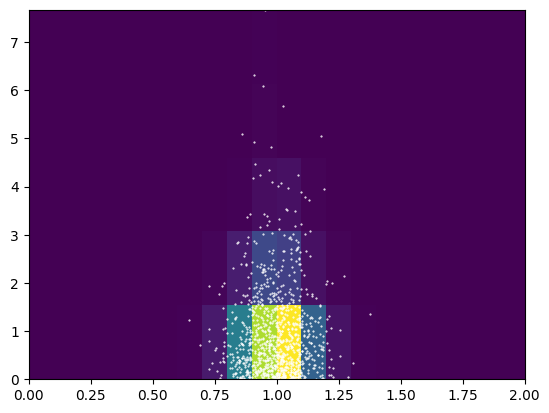

In [78]:
n2, _, ye = np.histogram2d(xdata, ydata, bins=(20, 5), range=(xr, (0, np.max(ydata))))

plt.pcolormesh(xe, ye, n2.T)
plt.scatter(xdata, ydata, marker=".", color="w", s=1);

## Maximum-likelihood fits

Maximum-likelihood fits are the state-of-the-art when it comes to fitting models to data. They can be applied to unbinned and binned data (histograms).

* Unbinned fits are the easiest to use, because no data binning is needed. They become slow when the sample size is large.
* Binned fits require you to appropriately bin the data. The binning has to be fine enough to retain all essential information. Binned fits are much faster when the sample size is large.

### Unbinned fit

Unbinned fits are ideal when the data samples are not too large or very high dimensional. There is no need to worry about the appropriate binning of the data. Unbinned fits are inefficient when the samples are very large and can become numerically unstable, too. Binned fits are a better choice then.

The cost function for an unbinned maximum-likelihood fit is really simple, it is the sum of the logarithm of the pdf evaluated at each sample point (times -1 to turn maximization into minimization). You can easily write this yourself, but a naive implementation will suffer from instabilities when the pdf becomes locally zero. Our implementation mitigates the instabilities to some extent.

To perform the unbinned fit you need to provide the pdf of the model, which must be vectorized (a Numpy ufunc). The pdf must be normalized, which means that the integral over the sample value range must be a constant for any combination of model parameters.

The model pdf in this case is a linear combination of the normal and the exponential pdfs. The parameters are $z$ (the weight), $\mu$ and $\sigma$ of the normal distribution and $\tau$ of the exponential. The cost function detects the parameter names.

It is important to put appropriate limits on the parameters, so that the problem does not become mathematically undefined.
* $0 < z < 1$,
* $\sigma > 0$,
* $\tau > 0$.

In addition, it can be beneficial to use $0 < \mu < 2$, but it is not required. We use `truncnorm` and `truncexpon`, which are normalized inside the data range (0, 2).

In [79]:
def pdf(x, z, mu, sigma, tau):
    return (z * truncnorm.pdf(x, *xr, mu, sigma) + 
            (1 - z) * truncexpon.pdf(x, *xr, 0.0, tau))

c = cost.UnbinnedNLL(xmix, pdf)

m = Minuit(c, z=0.4, mu=1, sigma=0.2, tau=1)
m.limits["z"] = (0, 1)
m.limits["mu"] = (0, 2)
m.limits["sigma", "tau"] = (0, None)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 768.1                      │              Nfcn = 111              │
│ EDM = 3.76e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ z     │   0.537   │   0.015   │            │            │    0    │    1    │       │
│ 1 │ mu    │   0.996   │   0.004   │            │            │    0    │    2    │       │
│ 2 │ sigma │  0.1006   │  0.0035   │            │            │    0    │         │       │
│ 3 │ tau   │   1.05    │   0.08    │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────────┐
│       │         z        mu     sigma       tau │
├───────┼─────────────────────────────────────────┤
│     z │  0.000231 -0.003e-3  0.019e-3  -0.24e-3 │
│    mu │ -0.003e-3   1.5e-05 -0.001e-3 -0.015e-3 │
│ sigma │  0.019e-3 -0.001e-3  1.25e-05 -0.043e-3 │
│   tau │  -0.24e-3 -0.015e-3 -0.043e-3   0.00568 │
└───────┴─────────────────────────────────────────┘

If the gradient of the model is available, it can be passed to the cost function to enable the computation of its gradient, which Minuit then uses to potentially improve the minimization. We use a numerically computed gradient here obtained from the `jacobi` library. This is for demonstration purpose only and generally not recommended, since `jacobi` computes the gradient much more accurately than what is required for Minuit.

In [80]:
def grad(x, *par):
    return jacobi(lambda par: pdf(x, *par), par)[0].T

c = cost.UnbinnedNLL(xmix, pdf, grad=grad)

m = Minuit(c, z=0.4, mu=1, sigma=0.2, tau=1)
m.limits["z"] = (0, 1)
m.limits["mu"] = (0, 2)
m.limits["sigma", "tau"] = (0, None)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 768.1                      │         Nfcn = 87, Ngrad = 5         │
│ EDM = 3.31e-05 (Goal: 0.0002)    │            time = 0.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ z     │   0.537   │   0.015   │            │            │    0    │    1    │       │
│ 1 │ mu    │   0.996   │   0.004   │            │            │    0    │    2    │       │
│ 2 │ sigma │  0.1006   │  0.0035   │            │            │    0    │         │       │
│ 3 │ tau   │   1.05    │   0.08    │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────────┐
│       │         z        mu     sigma       tau │
├───────┼─────────────────────────────────────────┤
│     z │  0.000231 -0.003e-3  0.019e-3  -0.24e-3 │
│    mu │ -0.003e-3   1.5e-05 -0.001e-3 -0.015e-3 │
│ sigma │  0.019e-3 -0.001e-3  1.25e-05 -0.043e-3 │
│   tau │  -0.24e-3 -0.015e-3 -0.043e-3   0.00569 │
└───────┴─────────────────────────────────────────┘

We can also fit a multivariate model to multivariate data. We pass model as a logpdf this time, which works well because the pdfs factorize.

In [81]:
def logpdf(xy, mu, sigma, tau):
    x, y = xy
    return (norm.logpdf(x, mu, sigma) + expon.logpdf(y, 0, tau))

c = cost.UnbinnedNLL((xdata, ydata), logpdf, log=True)
m = Minuit(c, mu=1, sigma=2, tau=2)
m.limits["sigma", "tau"] = (0, None)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 147.6                      │              Nfcn = 134              │
│ EDM = 2.1e-06 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu    │  0.9946   │  0.0031   │            │            │         │         │       │
│ 1 │ sigma │  0.0986   │  0.0022   │            │            │    0    │         │       │
│ 2 │ tau   │   0.972   │   0.031   │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬────────────────────────────┐
│       │       mu    sigma      tau │
├───────┼────────────────────────────┤
│    mu │ 9.73e-06     0e-6    -0e-6 │
│ sigma │     0e-6 4.86e-06    -0e-6 │
│   tau │    -0e-6    -0e-6 0.000944 │
└───────┴────────────────────────────┘

And we can also use a gradient as before.

In [84]:
def grad(xy, *par):
    return jacobi(lambda p: logpdf(xy, *p), par)[0].T

c = cost.UnbinnedNLL((xdata, ydata), logpdf, log=True, grad=grad)
m = Minuit(c, mu=1, sigma=2, tau=2)
m.limits["sigma", "tau"] = (0, None)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 147.6                      │         Nfcn = 81, Ngrad = 9         │
│ EDM = 3.73e-05 (Goal: 0.0002)    │            time = 0.1 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu    │  0.9946   │  0.0031   │            │            │         │         │       │
│ 1 │ sigma │  0.0986   │  0.0022   │            │            │    0    │         │       │
│ 2 │ tau   │   0.972   │   0.031   │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬────────────────────────────┐
│       │       mu    sigma      tau │
├───────┼────────────────────────────┤
│    mu │ 9.73e-06     0e-6    -0e-6 │
│ sigma │     0e-6 4.87e-06    -0e-6 │
│   tau │    -0e-6    -0e-6 0.000944 │
└───────┴────────────────────────────┘

### Extended unbinned fit

An important variant of the unbinned ML fit is described by [Roger Barlow, Nucl.Instrum.Meth.A 297 (1990) 496-506](https://inspirehep.net/literature/297773). Use this if both the shape and the integral of the density are of interest. In practice, this is often the case, for example, if you want to estimate a cross-section or yield.

The model in this case has to return the integral of the density and the density itself (which must be vectorized). The parameters in this case are those already discussed in the previous section and in addition $s$ (integral of the signal density), $b$ (integral of the uniform density). The additional limits are:

* $s > 0$,
* $b > 0$.

Compared to the previous case, we have one more parameter to fit.

In [ ]:
def density(x, s, b, mu, sigma, tau):
    return s + b, (
        s * truncnorm.pdf(x, *xr, mu, sigma) + b * truncexpon.pdf(x, *xr, 0, tau)
    )


c = cost.ExtendedUnbinnedNLL(xmix, density)

m = Minuit(c, s=300, b=1500, mu=0, sigma=0.2, tau=2)
m.limits["s", "b", "sigma", "tau"] = (0, None)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -2.388e+04                 │              Nfcn = 362              │
│ EDM = 2.8e-07 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ s     │  1.01e3   │  0.04e3   │            │            │    0    │         │       │
│ 1 │ b     │    872    │    35     │            │            │    0    │         │       │
│ 2 │ mu    │   0.996   │   0.004   │            │            │         │         │       │
│ 3 │ sigma │  0.1006   │  0.0035   │            │            │    0    │         │       │
│ 4 │ tau   │   1.05    │   0.08    │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬────────────────────────────────────────────────────────┐
│       │          s          b         mu      sigma        tau │
├───────┼────────────────────────────────────────────────────────┤
│     s │   1.36e+03     -0.4e3  -5.740e-3  35.547e-3     -0.440 │
│     b │     -0.4e3   1.22e+03   5.739e-3 -35.543e-3      0.440 │
│    mu │  -5.740e-3   5.739e-3    1.5e-05  -0.001e-3  -0.015e-3 │
│ sigma │  35.547e-3 -35.543e-3  -0.001e-3   1.25e-05  -0.043e-3 │
│   tau │     -0.440      0.440  -0.015e-3  -0.043e-3    0.00568 │
└───────┴────────────────────────────────────────────────────────┘

The fitted values and the uncertainty estimates for the shape parameters are identical to the previous fit.

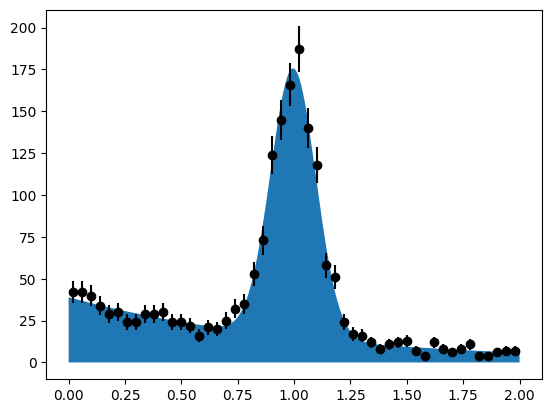

In [ ]:
m.visualize()

Once again, we fit 2D data, using the log-density mode.

In [ ]:
def logdensity(xy, n, mu, sigma, tau):
    x, y = xy
    return n, np.log(n) + norm.logpdf(x, mu, sigma) + expon.logpdf(y, 0, tau)

c = cost.ExtendedUnbinnedNLL((xdata, ydata), logdensity, log=True)
m = Minuit(c, n=1, mu=1, sigma=2, tau=2)
m.limits["n", "sigma", "tau"] = (0, None)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1.167e+04                 │              Nfcn = 328              │
│ EDM = 4.42e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ n     │   1000    │    32     │            │            │    0    │         │       │
│ 1 │ mu    │  0.9946   │  0.0031   │            │            │         │         │       │
│ 2 │ sigma │  0.0986   │  0.0022   │            │            │    0    │         │       │
│ 3 │ tau   │   0.972   │   0.031   │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────┐
│       │        n       mu    sigma      tau │
├───────┼─────────────────────────────────────┤
│     n │    1e+03     0e-6     0e-6       -0 │
│    mu │     0e-6 9.73e-06     0e-6    -0e-6 │
│ sigma │     0e-6     0e-6 4.86e-06    -0e-6 │
│   tau │       -0    -0e-6    -0e-6 0.000944 │
└───────┴─────────────────────────────────────┘

### Binned Fit

Binned fits are computationally more efficient and numerically more stable when samples are large. The caveat is that one has to choose an appropriate binning. The binning should be fine enough so that the essential information in the original is retained. Using large bins does not introduce a bias, but the parameters have a larger-than-minimal variance.

In this case, 50 bins are fine enough to retain all information. Using many bins is safe, since the maximum-likelihood method correctly takes Poisson statistics into account, which works even if bins have zero entries. Using more bins than necessary just increases the computational cost.

Instead of a pdf, you need to provide a cdf for a binned fit (which must be vectorized). 

In [ ]:
def cdf(xe, z, mu, sigma, tau):
    return (z * truncnorm.cdf(xe, *xr, mu, sigma) + 
            (1-z) * truncexpon.cdf(xe, *xr, 0, tau))

c = cost.BinnedNLL(n, xe, cdf)
m = Minuit(c, z=0.4, mu=0, sigma=0.2, tau=2)
m.limits["z"] = (0, 1)
m.limits["sigma", "tau"] = (0.01, None)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 15.03 (χ²/ndof = 0.9)      │              Nfcn = 270              │
│ EDM = 5.28e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ z     │   0.540   │   0.015   │            │            │    0    │    1    │       │
│ 1 │ mu    │   0.995   │   0.004   │            │            │         │         │       │
│ 2 │ sigma │   0.100   │   0.004   │            │            │  0.01   │         │       │
│ 3 │ tau   │   1.05    │   0.08    │            │            │  0.01   │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────────┐
│       │         z        mu     sigma       tau │
├───────┼─────────────────────────────────────────┤
│     z │  0.000235 -0.004e-3  0.020e-3  -0.24e-3 │
│    mu │ -0.004e-3  1.63e-05 -0.001e-3 -0.015e-3 │
│ sigma │  0.020e-3 -0.001e-3  1.43e-05 -0.045e-3 │
│   tau │  -0.24e-3 -0.015e-3 -0.045e-3   0.00564 │
└───────┴─────────────────────────────────────────┘

iminuit also shows the chi-square goodness-of-fit test statistic when the data are binned. It is calculated for free in the binned case.

Sometimes the cdf is expensive to calculate. In this case, you can approximate it via the cumulated sum of "bin-width times pdf evaluated at center". This approxmiation may lead to a bias. Using an accurate cdf avoids this bias.

Here is the same example fitted with an approximate cdf.

In [ ]:
def pdf(x, z, mu, sigma, tau):
    return z * truncnorm.pdf(x, *xr, mu, sigma) + (1 - z) * truncexpon.pdf(
        x, *xr, 0, tau
    )


def approximate_cdf(xe, z, mu, sigma, tau):
    dx = np.diff(xe)
    cx = xe[:-1] + 0.5 * dx
    p = pdf(cx, z, mu, sigma, tau)
    return np.append([0], np.cumsum(p * dx))


c = cost.BinnedNLL(n, xe, approximate_cdf)
m = Minuit(c, z=0.4, mu=0, sigma=0.2, tau=2)
m.limits["z"] = (0, 1)
m.limits["sigma", "tau"] = (0.01, None)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 15.65 (χ²/ndof = 1.0)      │              Nfcn = 189              │
│ EDM = 1.07e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ z     │   0.540   │   0.015   │            │            │    0    │    1    │       │
│ 1 │ mu    │   0.995   │   0.004   │            │            │         │         │       │
│ 2 │ sigma │   0.104   │   0.004   │            │            │  0.01   │         │       │
│ 3 │ tau   │   1.05    │   0.08    │            │            │  0.01   │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────────┐
│       │         z        mu     sigma       tau │
├───────┼─────────────────────────────────────────┤
│     z │  0.000235 -0.004e-3  0.020e-3  -0.24e-3 │
│    mu │ -0.004e-3  1.63e-05 -0.001e-3 -0.015e-3 │
│ sigma │  0.020e-3 -0.001e-3  1.31e-05 -0.043e-3 │
│   tau │  -0.24e-3 -0.015e-3 -0.043e-3   0.00568 │
└───────┴─────────────────────────────────────────┘

The fitted values and the uncertainty estimates for $\mu$ and $\sigma$ are not identical to the unbinned fit, but very close. For practical purposes, the results are equivalent. This shows that the binning is fine enough to retain the essential information in the original data.

Since this approximation is useful in practice, the `BinnedNLL` computes it automatically if you pass the keyword `use_pdf="approximate"`.

In [ ]:
c = cost.BinnedNLL(n, xe, pdf, use_pdf="approximate")
m = Minuit(c, z=0.4, mu=0, sigma=0.2, tau=2)
m.limits["z"] = (0, 1)
m.limits["sigma", "tau"] = (0.01, None)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 15.65 (χ²/ndof = 1.0)      │              Nfcn = 189              │
│ EDM = 1.06e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ z     │   0.540   │   0.015   │            │            │    0    │    1    │       │
│ 1 │ mu    │   0.995   │   0.004   │            │            │         │         │       │
│ 2 │ sigma │   0.104   │   0.004   │            │            │  0.01   │         │       │
│ 3 │ tau   │   1.05    │   0.08    │            │            │  0.01   │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────────┐
│       │         z        mu     sigma       tau │
├───────┼─────────────────────────────────────────┤
│     z │  0.000235 -0.004e-3  0.020e-3  -0.24e-3 │
│    mu │ -0.004e-3  1.63e-05 -0.001e-3 -0.015e-3 │
│ sigma │  0.020e-3 -0.001e-3  1.31e-05 -0.043e-3 │
│   tau │  -0.24e-3 -0.015e-3 -0.043e-3   0.00568 │
└───────┴─────────────────────────────────────────┘

Another option is to compute the cdf numerically with `use_pdf="numerical"`, but this tends to be expensive and is only supported for 1D histograms.

In [ ]:
c = cost.BinnedNLL(n, xe, pdf, use_pdf="numerical")
m = Minuit(c, z=0.4, mu=0, sigma=0.2, tau=2)
m.limits["z"] = (0, 1)
m.limits["sigma", "tau"] = (0.01, None)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 15.03 (χ²/ndof = 0.9)      │              Nfcn = 270              │
│ EDM = 5.28e-06 (Goal: 0.0002)    │            time = 2.0 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ z     │   0.540   │   0.015   │            │            │    0    │    1    │       │
│ 1 │ mu    │   0.995   │   0.004   │            │            │         │         │       │
│ 2 │ sigma │   0.100   │   0.004   │            │            │  0.01   │         │       │
│ 3 │ tau   │   1.05    │   0.08    │            │            │  0.01   │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────────┐
│       │         z        mu     sigma       tau │
├───────┼─────────────────────────────────────────┤
│     z │  0.000235 -0.004e-3  0.020e-3  -0.24e-3 │
│    mu │ -0.004e-3  1.63e-05 -0.001e-3 -0.015e-3 │
│ sigma │  0.020e-3 -0.001e-3  1.43e-05 -0.045e-3 │
│   tau │  -0.24e-3 -0.015e-3 -0.045e-3   0.00564 │
└───────┴─────────────────────────────────────────┘

Fitting a multidimensional histogram is equally easy. Since the pdfs in this example factorise, the cdf of the 2D model is the product of the cdfs along each axis.

In [ ]:
def cdf(xe_ye, mu, sigma, tau):
    xe, ye = xe_ye
    return norm.cdf(xe, mu, sigma) * expon.cdf(ye, 0, tau)

c = cost.BinnedNLL(n2, (xe, ye), cdf)
m = Minuit(c, mu=0.1, sigma=0.2, tau=2)
m.limits["sigma", "tau"] = (0, None)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 25.22 (χ²/ndof = 0.3)      │              Nfcn = 206              │
│ EDM = 9.93e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu    │  0.9932   │  0.0032   │            │            │         │         │       │
│ 1 │ sigma │  0.0984   │  0.0024   │            │            │    0    │         │       │
│ 2 │ tau   │   0.940   │   0.033   │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬────────────────────────────┐
│       │       mu    sigma      tau │
├───────┼────────────────────────────┤
│    mu │ 1.05e-05     0e-6       -0 │
│ sigma │     0e-6 5.68e-06     0e-6 │
│   tau │       -0     0e-6   0.0011 │
└───────┴────────────────────────────┘

The automatically provided visualization for multidimensional data set is often not very pretty, but still helps to judge whether the fit is reasonable. There is no obvious way to draw higher dimensional data with error bars in comparison to a model, and so the automatic visualization shows all data bins as a single sequence. You can override the default visualization by calling `Minuit.visualize` with your own plotting function, or by assigning a plot function to the cost function `BinnedNLL` (monkey patching), or by deriving your own class from `BinnedNLL`.

### Extended binned maximum-likelihood fit

As in the unbinned case, the binned extended maximum-likelihood fit should be used when also the amplitudes of the pdfs are of interest.

Instead of a density, you need to provide the integrated density in this case (which must be vectorized). There is no need to separately return the total integral of the density, like in the unbinned case. The parameters are the same as in the unbinned extended fit.

In [ ]:
def integral(xe, s, b, mu, sigma, tau):
    return (s * truncnorm.cdf(xe, *xr, mu, sigma) +
            b * truncexpon.cdf(xe, *xr, 0, tau))

c = cost.ExtendedBinnedNLL(n, xe, integral)
m = Minuit(c, s=300, b=1500, mu=0, sigma=0.2, tau=2)
m.limits["s", "b", "sigma", "tau"] = (0, None)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 15.03 (χ²/ndof = 1.0)      │              Nfcn = 437              │
│ EDM = 9.97e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ s     │  1.02e3   │  0.04e3   │            │            │    0    │         │       │
│ 1 │ b     │    867    │    35     │            │            │    0    │         │       │
│ 2 │ mu    │   0.995   │   0.004   │            │            │         │         │       │
│ 3 │ sigma │   0.100   │   0.004   │            │            │    0    │         │       │
│ 4 │ tau   │   1.05    │   0.08    │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬────────────────────────────────────────────────────────┐
│       │          s          b         mu      sigma        tau │
├───────┼────────────────────────────────────────────────────────┤
│     s │   1.38e+03     -0.4e3  -7.764e-3  38.616e-3     -0.452 │
│     b │     -0.4e3   1.23e+03   7.764e-3 -38.615e-3      0.452 │
│    mu │  -7.764e-3   7.764e-3   1.63e-05  -0.001e-3  -0.015e-3 │
│ sigma │  38.616e-3 -38.615e-3  -0.001e-3   1.43e-05  -0.045e-3 │
│   tau │     -0.452      0.452  -0.015e-3  -0.045e-3    0.00564 │
└───────┴────────────────────────────────────────────────────────┘

Again, we can also fit multivariate data.

In [ ]:
def integral(xe_ye, n, mu, sigma, tau):
    xe, ye = xe_ye
    return n * norm.cdf(xe, mu, sigma) * expon.cdf(ye, 0, tau)

c = cost.ExtendedBinnedNLL(n2, (xe, ye), integral)
m = Minuit(c, n=1500, mu=0.1, sigma=0.2, tau=2)
m.limits["n", "sigma", "tau"] = (0, None)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 24.64 (χ²/ndof = 0.3)      │              Nfcn = 182              │
│ EDM = 5.24e-08 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ n     │  1.000e3  │  0.032e3  │            │            │    0    │         │       │
│ 1 │ mu    │  0.9932   │  0.0032   │            │            │         │         │       │
│ 2 │ sigma │  0.0984   │  0.0024   │            │            │    0    │         │       │
│ 3 │ tau   │   0.943   │   0.034   │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────┐
│       │        n       mu    sigma      tau │
├───────┼─────────────────────────────────────┤
│     n │    1e+03        0    -0e-6   0.0029 │
│    mu │        0 1.05e-05     0e-6       -0 │
│ sigma │    -0e-6     0e-6 5.68e-06     0e-6 │
│   tau │   0.0029       -0     0e-6  0.00113 │
└───────┴─────────────────────────────────────┘

### Temporary masking

In complicated binned fits with peak and background, it is sometimes useful to fit in several stages. One typically starts by masking the signal region, to fit only the background region.

The cost functions have a mask attribute to that end. We demonstrate the use of the mask with an extended binned fit.

In [ ]:
def integral(xe, s, b, mu, sigma, tau):
    return (s * truncnorm.cdf(xe, *xr, mu, sigma) +
            b * truncexpon.cdf(xe, *xr, 0, tau))

c = cost.ExtendedBinnedNLL(n, xe, integral)

# we set the signal amplitude to zero and fix all signal parameters
m = Minuit(c, s=0, b=1500, mu=1, sigma=0.2, tau=2)

m.limits["s", "b", "sigma", "tau"] = (0, None)
m.fixed["s", "mu", "sigma"] = True

# we temporarily mask out the signal
c.mask = (cx < 0.5) | (1.5 < cx)

m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 6.623 (χ²/ndof = 0.8)      │              Nfcn = 55               │
│ EDM = 3.75e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ s     │    0.0    │    0.1    │            │            │    0    │         │  yes  │
│ 1 │ b     │    870    │    40     │            │            │    0    │         │       │
│ 2 │ mu    │   1.00    │   0.01    │            │            │         │         │  yes  │
│ 3 │ sigma │   0.200   │   0.002   │            │            │    0    │         │  yes  │
│ 4 │ tau   │   1.02    │   0.08    │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬──────────────────────────────────────────────┐
│       │        s        b       mu    sigma      tau │
├───────┼──────────────────────────────────────────────┤
│     s │        0        0        0        0    0.000 │
│     b │        0 1.71e+03        0        0    0.950 │
│    mu │        0        0        0        0    0.000 │
│ sigma │        0        0        0        0    0.000 │
│   tau │    0.000    0.950    0.000    0.000  0.00632 │
└───────┴──────────────────────────────────────────────┘

We plot the intermediate result. Points which have been masked out are shown with open markers.

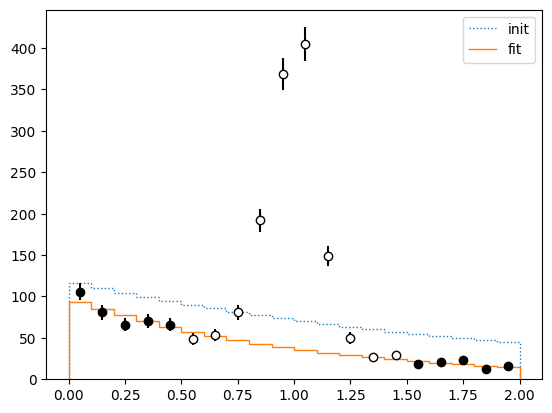

In [ ]:
for ma, co in ((c.mask, "k"), (~c.mask, "w")):
    plt.errorbar(cx[ma], n[ma], n[ma] ** 0.5, fmt="o", color=co, mec="k", ecolor="k")
plt.stairs(np.diff(integral(xe, *[p.value for p in m.init_params])), xe,
           ls=":", label="init")
plt.stairs(np.diff(integral(xe, *m.values)), xe, label="fit")
plt.legend();

Now we fix the background and fit only the signal parameters.

In [ ]:
c.mask = None # remove mask
m.fixed = False # release all parameters
m.fixed["b"] = True # fix background amplitude
m.values["s"] = 100 # do not start at the limit
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 15.03 (χ²/ndof = 0.9)      │              Nfcn = 252              │
│ EDM = 6.92e-09 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ s     │  1.017e3  │  0.035e3  │            │            │    0    │         │       │
│ 1 │ b     │    870    │    40     │            │            │    0    │         │  yes  │
│ 2 │ mu    │   0.995   │   0.004   │            │            │         │         │       │
│ 3 │ sigma │   0.100   │   0.004   │            │            │    0    │         │       │
│ 4 │ tau   │   1.05    │   0.07    │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────────────────────────────────────┐
│       │         s         b        mu     sigma       tau │
├───────┼───────────────────────────────────────────────────┤
│     s │   1.2e+03         0 -4.088e-3 27.177e-3    -0.485 │
│     b │         0         0         0         0     0.000 │
│    mu │ -4.088e-3         0  1.55e-05 -0.001e-3 -0.013e-3 │
│ sigma │ 27.177e-3         0 -0.001e-3   1.3e-05 -0.032e-3 │
│   tau │    -0.485     0.000 -0.013e-3 -0.032e-3   0.00509 │
└───────┴───────────────────────────────────────────────────┘

Finally, we release all parameters and fit again to get the correct uncertainty estimates.

In [ ]:
m.fixed = None
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 15.03 (χ²/ndof = 1.0)      │              Nfcn = 323              │
│ EDM = 3.22e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ s     │  1.02e3   │  0.04e3   │            │            │    0    │         │       │
│ 1 │ b     │    867    │    35     │            │            │    0    │         │       │
│ 2 │ mu    │   0.995   │   0.004   │            │            │         │         │       │
│ 3 │ sigma │   0.100   │   0.004   │            │            │    0    │         │       │
│ 4 │ tau   │   1.05    │   0.08    │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬────────────────────────────────────────────────────────┐
│       │          s          b         mu      sigma        tau │
├───────┼────────────────────────────────────────────────────────┤
│     s │   1.38e+03     -0.4e3  -7.764e-3  38.617e-3     -0.452 │
│     b │     -0.4e3   1.23e+03   7.764e-3 -38.616e-3      0.452 │
│    mu │  -7.764e-3   7.764e-3   1.63e-05  -0.001e-3  -0.015e-3 │
│ sigma │  38.617e-3 -38.616e-3  -0.001e-3   1.43e-05  -0.045e-3 │
│   tau │     -0.452      0.452  -0.015e-3  -0.045e-3    0.00564 │
└───────┴────────────────────────────────────────────────────────┘

We get the same result as before. Since this was an easy problem, we did not need these extra steps, but doing this can be helpful to fit lots of histograms without adjusting each fit manually.

### Weighted histograms

The cost functions for binned data also support weighted histograms. Just pass an array with the shape `(n, 2)` instead of `(n,)` as the first argument, where the first number of each pair is the sum of weights and the second is the sum of weights squared (an estimate of the variance of that bin value).

## Least-squares fits

A cost function for a general weighted least-squares fit (aka chi-square fit) is also included. In statistics this is called non-linear regression.

In this case you need to provide a model that predicts the y-values as a function of the x-values and the parameters. The fit needs estimates of the y-errors. If those are wrong, the fit may be biased. If your data has errors on the x-values as well, checkout the tutorial about automatic differentiation, which includes an application of that to such fits.

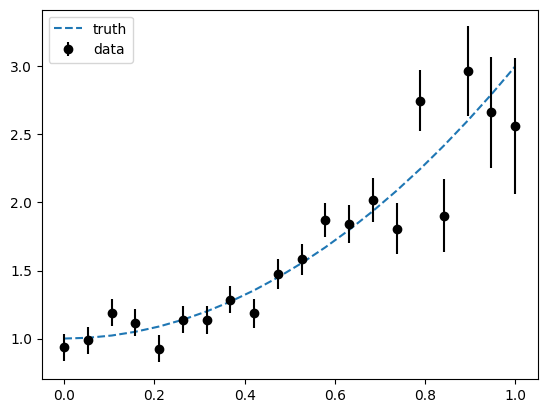

In [ ]:
def model(x, a, b):
    return a + b * x ** 2

rng = np.random.default_rng(4)

truth = 1, 2
x = np.linspace(0, 1, 20)
yt = model(x, *truth)
ye = 0.4 * x**5 + 0.1
y = rng.normal(yt, ye)

plt.plot(x, yt, ls="--", label="truth")
plt.errorbar(x, y, ye, fmt="ok", label="data")
plt.legend(loc="upper left");

In [ ]:
c = cost.LeastSquares(x, y, ye, model)
m1 = Minuit(c, a=0, b=0)
m1.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 25.29 (χ²/ndof = 1.4)      │              Nfcn = 29               │
│ EDM = 2.27e-22 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   0.99    │   0.04    │            │            │         │         │       │
│ 1 │ b    │   2.04    │   0.15    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────┐
│   │       a       b │
├───┼─────────────────┤
│ a │ 0.00139 -0.0037 │
│ b │ -0.0037  0.0226 │
└───┴─────────────────┘

We can also plot the standard visualization manually and add further graphs to the figure.

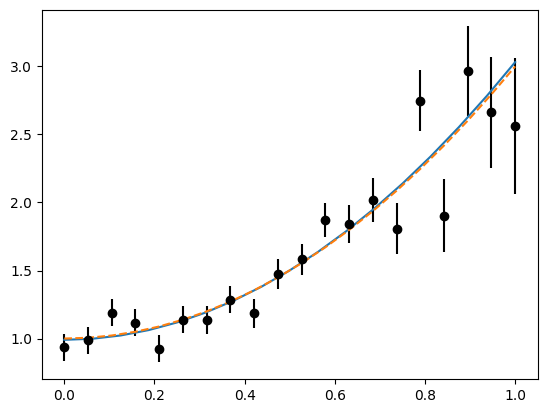

In [ ]:
m1.visualize()
plt.plot(c.x, model(c.x, *truth), ls="--", label="truth");

We can also fit a multivariate model, in this case we fit a plane in 2D.

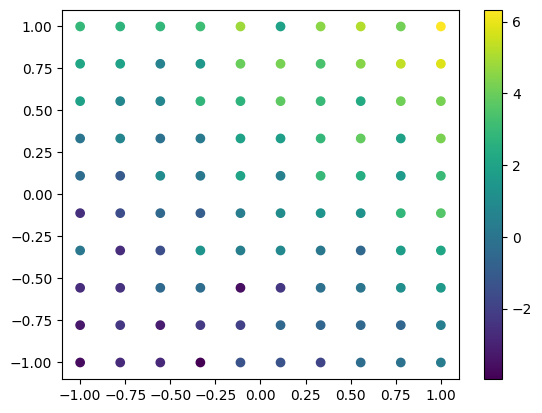

In [ ]:
def model2(x_y, a, bx, by):
    x, y = x_y
    return a + bx * x + by * y

# generate a regular grid in x and y
x = np.linspace(-1, 1, 10)
y = np.linspace(-1, 1, 10)
X, Y = np.meshgrid(x, y)
x = X.flatten()
y = Y.flatten()

# model truth
Z = model2((x, y), 1, 2, 3)

# add some noise
rng = np.random.default_rng(1)
Zerr = 1
Z = rng.normal(Z, Zerr)

plt.scatter(x, y, c=Z)
plt.colorbar();

In [ ]:
c2 = cost.LeastSquares((x, y), Z, Zerr, model2)
m2 = Minuit(c2, 0, 0, 0)
m2.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 71.61 (χ²/ndof = 0.7)      │              Nfcn = 34               │
│ EDM = 5.66e-16 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   0.93    │   0.10    │            │            │         │         │       │
│ 1 │ bx   │   1.87    │   0.16    │            │            │         │         │       │
│ 2 │ by   │   2.93    │   0.16    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬──────────────────────┐
│    │      a     bx     by │
├────┼──────────────────────┤
│  a │   0.01  0.000  0.000 │
│ bx │  0.000 0.0245  0.000 │
│ by │  0.000  0.000 0.0245 │
└────┴──────────────────────┘

Multivariate fits are difficult to check by eye. Here we use color to indicate the function value.

To guarantee that plot of the function and the plot of the data use the same color scale, we use the same normalising function for pyplot.pcolormesh and pyplot.scatter.

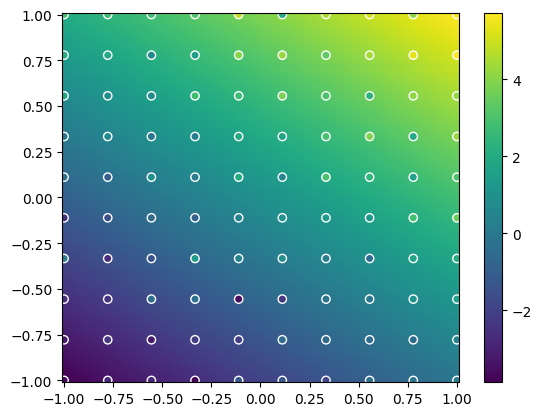

In [ ]:
xm = np.linspace(-1, 1, 100)
ym = np.linspace(-1, 1, 100)
Xm, Ym = np.meshgrid(xm, ym)
xm = Xm.flatten()
ym = Ym.flatten()

qm = plt.pcolormesh(Xm, Ym, model2((xm, ym), *m2.values).reshape(Xm.shape))
plt.scatter(c2.x[0], c2.x[1], c=c2.y, edgecolors="w", norm=qm.norm)
plt.colorbar();

### Robust least-squares

The built-in least-squares function also supports robust fitting with an alternative loss functions. See the documentation of `iminuit.cost.LeastSquares` for details. Users can pass their own loss functions. Builtin loss functions are:

* `linear` (default): gives ordinary weighted least-squares
* `soft_l1`: quadratic ordinary loss for small deviations ($\ll 1\sigma$), linear loss for large deviations ($\gg 1\sigma$), and smooth interpolation in between

Let's create one outlier and see what happens with ordinary loss.

In [ ]:
c.y[3] = 3 # generate an outlier

m3 = Minuit(c, a=0, b=0)
m3.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 364.9 (χ²/ndof = 20.3)     │              Nfcn = 29               │
│ EDM = 9.85e-22 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   1.23    │   0.04    │            │            │         │         │       │
│ 1 │ b    │   1.45    │   0.15    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────┐
│   │       a       b │
├───┼─────────────────┤
│ a │ 0.00139 -0.0037 │
│ b │ -0.0037  0.0226 │
└───┴─────────────────┘

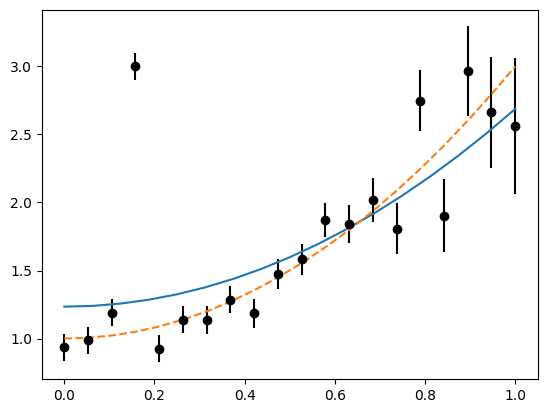

In [ ]:
m3.visualize()
plt.plot(c.x, model(c.x, 1, 2), ls="--", label="truth");

The result is distorted by the outlier. Note that the error did not increase! The size of the error computed by Minuit does **not** include mismodelling.

We can repair this with by switching to "soft_l1" loss.

In [ ]:
c.loss = "soft_l1"
m3.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 54.09 (χ²/ndof = 3.0)      │              Nfcn = 69               │
│ EDM = 4.31e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   1.00    │   0.05    │            │            │         │         │       │
│ 1 │ b    │   2.04    │   0.23    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────┐
│   │       a       b │
├───┼─────────────────┤
│ a │ 0.00285 -0.0086 │
│ b │ -0.0086  0.0524 │
└───┴─────────────────┘

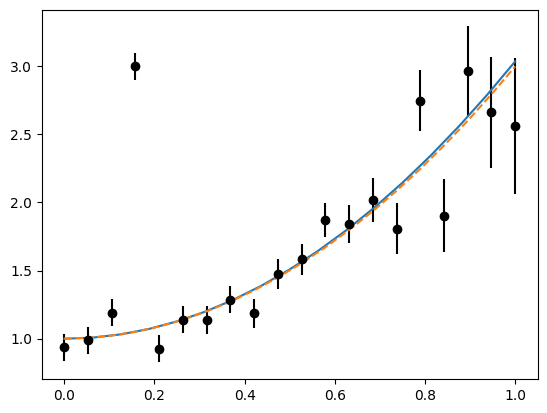

In [ ]:
m3.visualize()
plt.plot(c.x, model(c.x, *truth), ls="--", label="truth");

The result is almost identical as in the previous case without an outlier.

Robust fitting is very useful if the data are contaminated with small amounts of outliers. It comes with a price, however, the uncertainties are in general larger and the errors computed by Minuit are not correct anymore.

Calculating the parameter uncertainty properly for this case requires a so-called sandwich estimator, which is currently not implemented. As an alternative, one can use the bootstrap to compute parameter uncertainties. We use the `resample` library to do this.

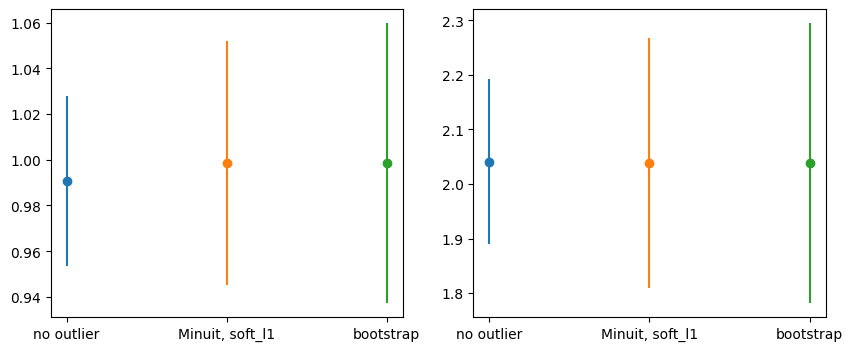

In [ ]:
from resample.bootstrap import variance as bvar

def fit(x, y, ye):
    c = cost.LeastSquares(x, y, ye, model, loss="soft_l1")
    m = Minuit(c, a=0, b=0)
    m.migrad()
    return m.values

berr = bvar(fit, c.x, c.y, c.yerror, size=1000, random_state=1) ** 0.5

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
for i, axi in enumerate(ax):
    axi.errorbar(0, m1.values[i], m1.errors[i], fmt="o")
    axi.errorbar(1, m3.values[i], m3.errors[i], fmt="o")
    axi.errorbar(2, m3.values[i], berr[i], fmt="o")
    axi.set_xticks(np.arange(3), ("no outlier", "Minuit, soft_l1", "bootstrap"));

In this case, Minuit's estimate is similar to the bootstrap estimate, but that is not generally true when the "soft_l1" loss is used.

Robust fits are very powerful when the outliers cannot be removed by other means. If one can identify outliers by other means, it is better to remove them. We manually remove the point (using the mask attribute) and switch back to ordinary loss.

In [ ]:
c.mask = np.arange(len(c.x)) != 3
c.loss = "linear"
m4 = Minuit(c, a=0, b=0)
m4.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 24.67 (χ²/ndof = 1.5)      │              Nfcn = 29               │
│ EDM = 1.37e-22 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   0.98    │   0.04    │            │            │         │         │       │
│ 1 │ b    │   2.07    │   0.15    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────┐
│   │       a       b │
├───┼─────────────────┤
│ a │ 0.00158 -0.0041 │
│ b │ -0.0041  0.0238 │
└───┴─────────────────┘

Now the uncertainties are essentially the same as before adding the outlier.

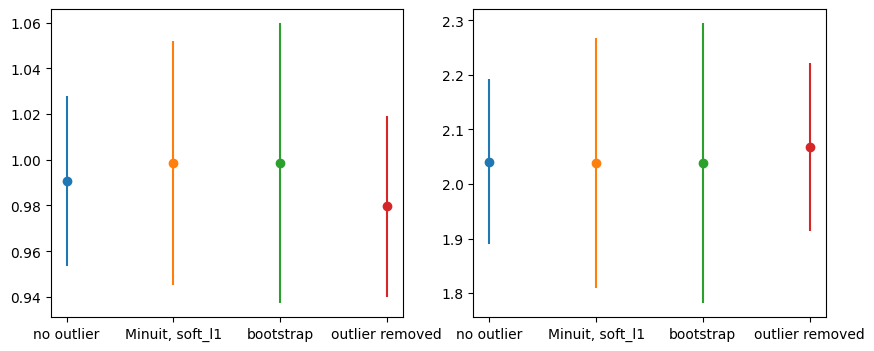

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
for i, axi in enumerate(ax):
    axi.errorbar(0, m1.values[i], m1.errors[i], fmt="o")
    axi.errorbar(1, m3.values[i], m3.errors[i], fmt="o")
    axi.errorbar(2, m3.values[i], berr[i], fmt="o")
    axi.errorbar(3, m4.values[i], m4.errors[i], fmt="o")
    axi.set_xticks(np.arange(4), ("no outlier", "Minuit, soft_l1", "bootstrap", "outlier removed"));